In [1]:
GPU_NUM = 0
GPU_NUM = str(GPU_NUM)
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_NUM

import gc
import h5py
import glob
import natsort
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from IPython.display import clear_output
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-white')

from scipy.signal import hilbert
import scipy.io
import torch
import torch.nn as nn
GPU = torch.device('cuda')
CPU = torch.device('cpu')
print(torch.cuda.is_available(), ': ', torch.cuda.get_device_name(0))

True :  NVIDIA GeForce RTX 2080 Ti


In [2]:
def imshow(img, cmap='viridis', aspect='auto', interpolation='bicubic', abs=True, log=True):
    if abs: img = np.abs(img)
    if log: img = 20*np.log10(img+1)
    plt.figure(figsize=(7, 6))
    plt.imshow(img, cmap=cmap, aspect=aspect, interpolation=interpolation)
    plt.colorbar()
    plt.show()

In [3]:
class DAS():
    def __init__(self, H_p=374, W_p=128, N=128, H_m=0.038, W_m=0.038, 
                 sos=1540, freq=7.6e+6, sampling=4.1118):
        '''
        H_p: Height of B_mode (Pixel)
        W_p: Weigth of B-mode (Pixel)
        N: Number of elements
        H_m: Height of B_mode (meter)
        W_m: Weigth of B-mode (meter)
        '''
        self.H_p = H_p
        self.W_p = W_p
        self.N = N
        self.H_m = H_m
        self.W_m = W_m
        self.sos = sos
        self.freq = freq
        self.sampling = sampling

        self.p2m_H = (H_m/H_p)
        self.p2m_W = (W_m/W_p)
        self.m2l = (freq/sos)
        self.l2s = sampling
        
        M1 = torch.linspace(1, H_p, H_p).unsqueeze(-1).unsqueeze(-1)
        M1 = M1.repeat(1, W_p, N)
        M1 *= self.p2m_H
        
        x = torch.linspace(1, H_p, H_p).unsqueeze(-1).unsqueeze(-1)
        y = torch.linspace(1, W_p, W_p).unsqueeze(+0).unsqueeze(-1)
        n = torch.linspace(1,   N,   N).unsqueeze(+0).unsqueeze(+0)
        x *= (self.p2m_H)
        y *= (self.p2m_W)
        n *= (self.p2m_W)
        M2 = ((y-n)**2 + x**2)**0.5
        
        M1 *= (self.m2l*self.l2s)
        M2 *= (self.m2l*self.l2s)
        M = M1+M2
        self.M1 = M1
        self.M2 = M2
        self.M1 = torch.round(M1).to(torch.int64)
        self.M2 = torch.round(M2).to(torch.int64)
        self.M = torch.round(M).to(torch.int64)
        print(f'{"Indexing Matrix":<30}: {M.shape}')
        
        self.idx_x = torch.linspace(1, H_p, H_p).to(torch.int64) - 1
        self.idx_y = torch.linspace(1, W_p, W_p).to(torch.int64) - 1
        self.idx_n = torch.linspace(1,   N,   N).to(torch.int64) - 1
        
    def das(self, RF, Ne=None, Nf=None, ensemble=True, PA=False, 
            DA=True, d1=0.3, d2=5, d3=1):
        '''
        Ne: Number of ensemble
        Nf: Number of frame
        DA: Dynamic Aperture
        '''
        if not isinstance(RF, torch.Tensor): RF = torch.tensor(RF).to(torch.float32)
        print(f'{"RF(Raw)":<30}: {RF.shape}')
        if Ne!=None: RF = RF[Ne, :, :, :]
        if Nf!=None: RF = RF[:, Nf, :, :]
        N = RF.shape[0]
        n = RF.shape[1]
        print(f'{"RF(Target)":<30}: {RF.shape}')
        
        if PA==False:
            RF_res = RF[:, :, self.M, self.idx_n]
        else:
            RF_res = RF[:, :, self.M2, self.idx_n]
        print(f'{"Extracted":<30}: {RF_res.shape}')
        
        # Dynamic Aperture
        if DA:
            list_sigma = torch.linspace(0.01, 1, self.H_p)**d1
            list_sigma = list_sigma*d2 + d3
            list_s = [-s for s in range(0, self.N)]
            x = torch.stack([torch.linspace(s, s+self.N-1, self.N) for s in list_s])
            mask = torch.stack([torch.exp(-0.5*(x/sigma)**2) for sigma in list_sigma]).unsqueeze(0).unsqueeze(0)
            RF_res = RF_res*mask
            print(f'{"Dynamic Aperture Mask":<30}: {mask.shape}')

        RF_res = torch.sum(RF_res, axis=-1)
        RF_res = RF_res.to(torch.float32)
        print(f'{"RF_res":<30}: {RF_res.shape}')
        
        if ensemble:
            RF_res = torch.mean(RF_res, axis=0)
            print(f'{"RF_res(AGG)":<30}: {RF_res.shape}')
        print('--'*30)
            
        return RF_res

In [4]:
class HP():
    def __init__(self):
        self.H = 374
        self.W = 128
        self.N = 128
        
        self.depth = 0.038
        self.width = 0.038
        self.p2m_H = (self.depth/self.H)
        self.p2m_W = (self.width/self.W)
        self.m2l = (7.6e+6/1540)
        self.l2s = 4.1118

hp = HP()
hp.__dict__

{'H': 374,
 'W': 128,
 'N': 128,
 'depth': 0.038,
 'width': 0.038,
 'p2m_H': 0.00010160427807486631,
 'p2m_W': 0.000296875,
 'm2l': 4935.064935064935,
 'l2s': 4.1118}

In [5]:
RF_data = scipy.io.loadmat('../data/data_sample.mat')['RF_data']
print('RF_data: ', RF_data.shape)

RF_data:  (1, 100, 2176, 128)


In [6]:
das = DAS()
res = das.das(RF_data)

Indexing Matrix               : torch.Size([374, 128, 128])
RF(Raw)                       : torch.Size([1, 100, 2176, 128])
RF(Target)                    : torch.Size([1, 100, 2176, 128])
Extracted                     : torch.Size([1, 100, 374, 128, 128])
Dynamic Aperture Mask         : torch.Size([1, 1, 374, 128, 128])
RF_res                        : torch.Size([1, 100, 374, 128])
RF_res(AGG)                   : torch.Size([100, 374, 128])
------------------------------------------------------------


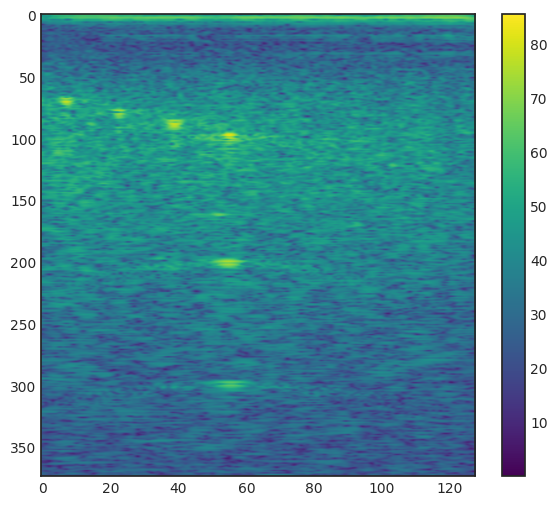

In [7]:
imshow(res[0])